Generate radio environment......


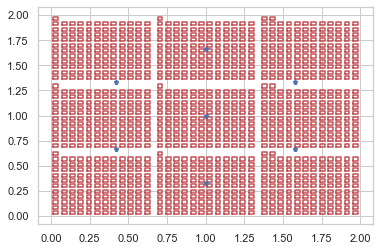

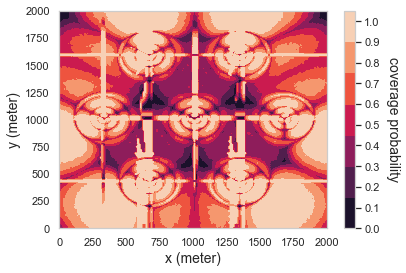

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 10:36:06 2019

@author: Xiaoli Xu and Yong Zeng
At each UAV location, get the empirical outage probability based on the measured signal strengths
"""


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
#import time 

print('Generate radio environment......')

# This part model the distribution of buildings
ALPHA=0.3
BETA=300
GAMA=50
MAXHeight=90

SIR_THRESHOLD=0 #SIR threshold in dB for outage


#==========================================
#==Simulate the building locations and building size. Each building is modeled by a square
D=2 #in km, consider the area of DxD km^2
N=BETA*(D**2) #the total number of buildings
A=ALPHA*(D**2)/N #the expected size of each building
Side=np.sqrt(A)

H_vec=np.random.rayleigh(GAMA,N)
H_vec=[min(x, MAXHeight) for x in H_vec]

#Grid distribution of buildings
Cluster_per_side=3
Cluster=Cluster_per_side**2
N_per_cluster=[np.ceil(N/Cluster) for i in range(Cluster)]

#Add some modification to ensure that the total number of buildings is N
Extra_building=int(np.sum(N_per_cluster)-N)
N_per_cluster[:(Extra_building-1)]=[np.ceil(N/Cluster)-1 for i in range(Extra_building)]

#============================
Road_width=0.02   #road width in km
Cluster_size=(D-(Cluster_per_side-1)*Road_width)/Cluster_per_side
Cluster_center=np.arange(Cluster_per_side)*(Cluster_size+Road_width)+Cluster_size/2
#=====Get the building locations=================
XLOC=[];
YLOC=[];

for i in range(Cluster_per_side):
    for j in range(Cluster_per_side):
        Idx=i*Cluster_per_side+j
        Buildings=int(N_per_cluster[Idx])
        Center_loc=[Cluster_center[i],Cluster_center[j]]
        Building_per_row=int(np.ceil(np.sqrt(Buildings)))
        Building_dist=(Cluster_size-2*Side)/(Building_per_row-1)
        X_loc=np.linspace((-Cluster_size+2*Side)/2,(Cluster_size-2*Side)/2,Building_per_row)
        Loc_tempX=np.array(list(X_loc)*Building_per_row)+Center_loc[0]
        Loc_tempY=np.repeat(list(X_loc),Building_per_row)+Center_loc[1]
        XLOC.extend(list(Loc_tempX[0:Buildings]))
        YLOC.extend(list(Loc_tempY[0:Buildings]))
        
#Sample the building Heights
step=101 #include the start point at 0 and end point, the space between two sample points is D/(step-1)
HeightMapMatrix=np.zeros(shape=(D*step,D*step))
HeighMapArray=HeightMapMatrix.reshape(1,(D*step)**2)
for i in range(N):
    x1=XLOC[i]-Side/2
    x2=XLOC[i]+Side/2
    y1=YLOC[i]-Side/2
    y2=YLOC[i]+Side/2
    HeightMapMatrix[int(np.ceil(x1*step)-1):int(np.floor(x2*step)),int(np.ceil(y1*step)-1):int(np.floor(y2*step))]=H_vec[i]

#=================END of Building distributions================================

#=============Define the BS Distribution=======================
BS_loc=np.array([[1, 1, 0.025], [1.5774,1.333, 0.025], [1, 1.6667,0.025,], [0.4226,1.3333,  0.025], [0.4226, 0.6667,  0.025], [1, 0.3333, 0.025], [1.5774,0.6667,  0.025]])
#BS_Height=25 #BS height in meters convert to location in km
BS_thetaD=100 # The downtile angle in degree [0, 180]
PB=0.1 #BS Transmit power in Watt
Fc=2 # Operating Frequency in GHz
LightSpeed=3*(10**8)
WaveLength=LightSpeed/(Fc*(10**9)) #wavelength in meter
SectorBoreSiteAngle=[-120,0,120] #the sector angle for each BS
Sec_num=np.size(SectorBoreSiteAngle) #the number of sectors per cell
FastFadingSampleSize=1000 #number of signal measurements per time step

#===========View Building and BS distributions
plt.figure()
for i in range(N):
    x1=XLOC[i]-Side/2
    x2=XLOC[i]+Side/2
    y1=YLOC[i]-Side/2
    y2=YLOC[i]+Side/2
    XList=[x1,x2,x2,x1,x1]
    YList=[y1,y1,y2,y2,y1]
    plt.plot(XList,YList,'r-')

plt.plot(BS_loc[:,0],BS_loc[:,1],'bp',markersize=5)

#==============================================================================
#To speed up, we pre-store the atenna gain from different angles into a matrix
def getAntennaGain(Theta_deg,Phi_deg):
    #Basic Setting about Antenna Arrays
    ArrayElement_Horizontal=1 #number of array elements in horizontal 
    ArrayElement_Vertical=8
    DV=0.5*WaveLength #spacing for vertical array
    DH=0.5*WaveLength #spacing for horizontal array
    angleTiltV=BS_thetaD
    angleTiltH=0 #horizontal tilt angle
    #Find the element power gain
    angle3dB=65
    Am=30
    AH=-np.min([12*(Phi_deg/angle3dB)**2,Am]) #element power gain in horizontal
    AV=-np.min([12*((Theta_deg-90)/angle3dB)**2,Am]) #element power gain in Vertical
    Gemax=8 # dBi antenna gain in dB above an isotropic radiator, Maximum directional gain of an antenna element
    Aelement=-np.min([-(AH+AV),Am])
    GelementdB=Gemax+Aelement #dBi
    Gelement=10**(GelementdB/10)
    Felement=np.sqrt(Gelement)
    #Find array gain
    k=2*np.pi/WaveLength #wave number
    kVector=k*np.array([np.sin(Theta_deg/180*np.pi)*np.cos(Phi_deg/180*np.pi),np.sin(Theta_deg/180*np.pi)*np.sin(Phi_deg/180*np.pi),np.cos(Theta_deg/180*np.pi)]) #wave vector
    rMatrix=np.zeros(shape=(ArrayElement_Horizontal*ArrayElement_Vertical,3))
    for n in range(ArrayElement_Horizontal):
        rMatrix[(n+1)*np.arange(ArrayElement_Vertical),2]=np.arange(ArrayElement_Vertical)*DV
        rMatrix[(n+1)*np.arange(ArrayElement_Vertical),1]=n*DH
    SteeringVector=np.exp(-1j*(rMatrix.dot(np.transpose(kVector))))
    #Vertical Weight Vector
    Weight_Vertical=(1/np.sqrt(ArrayElement_Vertical))*np.exp(-1j*k*np.arange(ArrayElement_Vertical)*DV*np.cos(angleTiltV/180*np.pi))
    Weight_Horizontal=(1/np.sqrt(ArrayElement_Horizontal))*np.exp(-1j*k*np.arange(ArrayElement_Horizontal)*DH*np.sin(angleTiltH/180*np.pi))
    Weight2D=np.kron(Weight_Horizontal,np.transpose(Weight_Vertical))
    WeightFlatten=Weight2D.reshape(1,ArrayElement_Vertical*ArrayElement_Horizontal)
    ArrayFactor=np.conjugate(WeightFlatten).dot(SteeringVector.reshape(ArrayElement_Vertical,1))
    Farray=Felement*ArrayFactor
    Garray=(np.abs(Farray))**2
    return 10*np.log10(Garray),Farray

#================get All the Antenna gain====================
angleVvector=np.arange(181) #vertical angle from 0 to 180
angleHvector=np.linspace(-180,179,360)
numV=np.size(angleVvector)
numH=np.size(angleHvector)
GarraydBmatrix=np.zeros(shape=(numV,numH)) #pre-stored atenna gain
FtxMatrix=np.zeros(shape=(numV,numH),dtype=complex) #pre-stored array factor
for p in range(numV):
    for q in range(numH):
        GarraydBmatrix[p,q],FtxMatrix[p,q]=getAntennaGain(angleVvector[p],angleHvector[q])
#==============================================================================

#=========Main Function that determines the best outage from all BS at a given location=======
#loc_vec: a matrix, nx3, each row is a (x,y,z) location
#SIR_th: the SIR threshold for determining outage
def getPointMiniOutage(loc_vec):
    numLoc=len(loc_vec)
    Out_vec=[]
    for i in range(numLoc):
        PointLoc=loc_vec[i,:]
        OutageMatrix=getPointOutageMatrix(PointLoc,SIR_THRESHOLD)
        MiniOutage=np.min(OutageMatrix)
        Out_vec.append(MiniOutage)
    return Out_vec

#For a given location, return the empirical outage probaibility from all sectors of all BSs
#PointLoc:  the given point location
#SIR_th: the SIR threshold for defining the outage 
#OutageMatrix: The average outage probability for connecting with each site, obtained by averaging over all the samples
def getPointOutageMatrix(PointLoc,SIR_th):
    numBS=len(BS_loc)
    SignalFromBS=[]
    TotalPower=0
    for i in range(len(BS_loc)):
        BS=BS_loc[i,:]
        LoS=checkLoS(PointLoc,BS)
        MeasuredSignal=getReceivedPower_RicianAndRayleighFastFading(PointLoc,BS,LoS)
        SignalFromBS.append(MeasuredSignal)
        TotalPower=TotalPower+MeasuredSignal
    TotalPowerAllSector=np.sum(TotalPower, axis=1) #the interference of all power
    OutageMatrix=np.zeros(shape=(numBS,Sec_num))
    for i in range(len(BS_loc)):
        SignalFromThisBS=SignalFromBS[i]
        for sector in range(Sec_num):
            SignalFromThisSector=SignalFromThisBS[:,sector]
            SIR=SignalFromThisSector/(TotalPowerAllSector-SignalFromThisSector)
            SIR_dB=10*np.log10(SIR)
            OutageMatrix[i,sector]=np.sum(SIR_dB<SIR_th)/len(SIR_dB)
    return OutageMatrix

              
      
#Return the received power at a location from all the three sectors of a BS
#While the large scale path loss power is a constant for given location and site, the fast fading may change very fast. 
#Hence, we return multiple fast fading coefficients. The number of samples is determined by FastFadingSampleSize
#A simple fast-fading implementation: if LoS, Rician fading with K factor 15 dB; otherwise, Rayleigh fading
def getReceivedPower_RicianAndRayleighFastFading(PointLoc,BS,LoS):
    HorizonDistance=np.sqrt((BS[0]-PointLoc[0])**2+(BS[1]-PointLoc[1])**2)
    Theta=np.arctan((BS[2]-PointLoc[2])/HorizonDistance) #elevation angle
    Theta_deg=np.rad2deg(Theta)+90 #convert to the (0,180) degree
    if (PointLoc[1]==BS[1])&(PointLoc[0]==BS[0]):
        Phi=0
    else:
        Phi=np.arctan((PointLoc[1]-BS[1])/(PointLoc[0]-BS[0]+0.00001)) # to avoid dividing by 0
    Phi_deg=np.rad2deg(Phi)
    #Convert the horizontal degree to the range (-180,180)
    if (PointLoc[1]>BS[1])&(PointLoc[0]<BS[0]):
        Phi_deg=Phi_deg+180
    elif (PointLoc[1]<BS[1])&(PointLoc[0]<BS[0]):
        Phi_deg=Phi_deg-180
    LargeScale=getLargeScalePowerFromBS(PointLoc,BS,Theta_deg,Phi_deg,LoS) #large-scale received power based on path loss
    
    #the random component, which is Rayleigh fading
    RayleighComponent=np.sqrt(0.5)*(np.random.randn(FastFadingSampleSize,3)+1j*np.random.randn(FastFadingSampleSize,3))
    
    if LoS:#LoS, fast fading is given by Rician fading with K factor 15 dB
        K_R_dB=15 #Rician K factor in dB
        K_R=10**(K_R_dB/10)
        threeD_distance=1000*np.sqrt((BS[0]-PointLoc[0])**2+(BS[1]-PointLoc[1])**2+(BS[2]-PointLoc[2])**2)#3D distance in meter
        DetermComponent=np.exp(-1j*2*np.pi*threeD_distance/WaveLength) #deterministic component
        AllFastFadingCoef=np.sqrt(K_R/(K_R+1))*DetermComponent+np.sqrt(1/(K_R+1))*RayleighComponent
    else:#NLoS, fast fading is Rayleigh fading  
        AllFastFadingCoef=RayleighComponent

    h_overall=AllFastFadingCoef*np.sqrt(np.tile(LargeScale,(FastFadingSampleSize,1)))
    PowerInstant=np.abs(h_overall)**2 #the instantneous received power in Watt
    return PowerInstant


#This function check whether there is LoS between the BS and the given Loc
def checkLoS(PointLoc,BS):
    SamplePoints=np.linspace(0,1,100)
    XSample=BS[0]+SamplePoints*(PointLoc[0]-BS[0])
    YSample=BS[1]+SamplePoints*(PointLoc[1]-BS[1])
    ZSample=BS[2]+SamplePoints*(PointLoc[2]-BS[2])
    XRange=np.floor(XSample*(step-1))
    YRange=np.floor(YSample*(step-1)) #
    XRange=[max(x, 0) for x in XRange] #remove the negative idex
    YRange=[max(x, 0) for x in YRange] #remove the negative idex
    Idx_vec=np.int_((np.array(XRange)*D*step+np.array(YRange)))
    SelectedHeight=[HeighMapArray[0,i] for i in Idx_vec]
    if any([x>y for (x,y) in zip(SelectedHeight, ZSample)]):
        return False
    else:
        return True

def getLargeScalePowerFromBS(PointLoc,BS,Theta_deg,Phi_deg,LoS):
    Sector_num=len(SectorBoreSiteAngle)
    Phi_Sector_ref=Phi_deg-np.array(SectorBoreSiteAngle)
    #Convert to the range (-180,180) with respect to the sector angle
    Phi_Sector_ref[Phi_Sector_ref<-180]=Phi_Sector_ref[Phi_Sector_ref<-180]+360
    Phi_Sector_ref[Phi_Sector_ref>180]=Phi_Sector_ref[Phi_Sector_ref>180]-360
    ChGain_dB=np.zeros(shape=(1,Sector_num))
    for i in range(Sector_num):
        ChGain_dB[0,i],null=getAntennaGain(Theta_deg,Phi_Sector_ref[i])
    ChGain=np.power(10,ChGain_dB/10) #choose the sector that provides the maximal channel gain
    Distance=1000*np.sqrt((BS[0]-PointLoc[0])**2+(BS[1]-PointLoc[1])**2+(BS[2]-PointLoc[2])**2) #convert to meter
    #We use 3GPP TR36.777 Urban Macro Cell model to generate the path loss
    #UAV height between 22.5m and 300m
    if LoS:
        PathLoss_LoS_dB=28+22*np.log10(Distance)+20*np.log10(Fc)
        PathLoss_LoS_Linear=10**(-PathLoss_LoS_dB/10)
        Prx=ChGain*PB*PathLoss_LoS_Linear
    else:
        PathLoss_NLoS_dB=-17.5+(46-7*np.log10(PointLoc[2]*1000))*np.log10(Distance)+20*np.log10(40*np.pi*Fc/3)
        PathLoss_NLoS_Linear=10**(-PathLoss_NLoS_dB/10)
        Prx=ChGain*PB*PathLoss_NLoS_Linear
    return Prx


##the antenna gain viewed from vertical plane
#plt.axes(polar=True)
#plt.plot(np.deg2rad(angleVvector),GarraydBmatrix[:,180],c='k')
#plt.title('Vertical Antenna Gain with azimuth angle 0')
#plt.show()
#
##The antenna gain viewed from the horizontal plane
#plt.axes(polar=True)
#plt.plot(np.deg2rad(angleHvector),GarraydBmatrix[101,:],c='k')
#plt.title('Horizontal Antenna Gain with vertial angle 90')
#plt.show()
#
## 3D antenna gain
#THETA, PHI= np.meshgrid(np.deg2rad(angleHvector), np.deg2rad(angleVvector))
#R = GarraydBmatrix
#Rmax = np.max(R)
# 
#X = R * np.sin(THETA) * np.cos(PHI)
#Y = R * np.sin(THETA) * np.sin(PHI)
#Z = R * np.cos(THETA)
# 
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1, projection='3d')
#plot = ax.plot_surface(
#    X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
#    linewidth=0, antialiased=False, alpha=0.5)
#
#ax.view_init(30, 0)
#plt.show()
#======================================================
#Test the time for evaluating one point
#start_time = time.time()
#loc_vec=np.array([[1,1,0.1]]) #in km
#test=getPointMiniOutage(loc_vec) 
#print("--- %s seconds ---" %(time.time() - start_time))


##============VIew the radio map for given height
UAV_height=0.1 # UAV height in km
X_vec=range(D*(step-1)+1)
Y_vec=range(D*(step-1)+1)
numX,numY=np.size(X_vec),np.size(Y_vec)

OutageMapActual=np.zeros(shape=(numX,numY))
Loc_vec_All=np.zeros(shape=(numX*numY,3))

for i in range(numX):
    Loc_vec=np.zeros(shape=(numY,3))
    Loc_vec[:,0]=X_vec[i]/step
    Loc_vec[:,1]=np.array(Y_vec)/step
    Loc_vec[:,2]=UAV_height
    
    Loc_vec_All[i*numY:(i+1)*numY,:]=Loc_vec
    
    OutageMapActual[i,:]=getPointMiniOutage(Loc_vec)
#    print(OutageMap[i,:])

Outage_vec_All=np.reshape(OutageMapActual,numX*numY)


Test_Size=int(numX*numY/10)
test_indices=random.sample(range(numX*numY),Test_Size)
TEST_LOC_meter=Loc_vec_All[test_indices,:2]*1000
TEST_LOC_ACTUAL_OUTAGE=Outage_vec_All[test_indices]


#fig, ax=plt.subplots()
##plt.style.use('classic')
#cs = ax.contourf(X_vec*10,Y_vec*10,1-OutageMap)
#cbar=fig.colorbar(cs)
#plt.show()

fig=plt.figure(10)
#plt.style.use('classic')
plt.contourf(np.array(X_vec)*10,np.array(Y_vec)*10,1-OutageMapActual)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v)
cbar.set_label('coverage probability',labelpad=20, rotation=270,fontsize=14) 
plt.xlabel('x (meter)',fontsize=14)
plt.ylabel('y (meter)',fontsize=14)
plt.show()
fig.savefig('CoverageMapTrue.eps')
fig.savefig('CoverageMapTrue.pdf')
fig.savefig('CoverageMapTrue.jpg')
 
np.savez('radioenvir',OutageMapActual,X_vec,Y_vec,TEST_LOC_meter,TEST_LOC_ACTUAL_OUTAGE)